# Week 8: Data Visualisation with UMAP

In this notebook we will use UMAP to create visualisations of artworks from The Metropolitan Museum of Art.

In [6]:
# #install if you don't have these
# !pip install 'umap-learn==0.5.3' opencv-python scikit-image seaborn

In [1]:
import cv2, os, random, time, requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage import color
import seaborn as sns
from urllib.request import urlopen
from tensorflow.keras import applications
from skimage import io
from datetime import datetime
import glob

/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/umap/dist

In [2]:
def collect_data(directory_path, max_images=500):
    # Use glob pattern matching to find all image files
    pattern = os.path.join(directory_path, '*.jpg') 
    image_paths = glob.glob(pattern)
    # Limit the maximum number of images
    image_paths = image_paths[:max_images]
    if not image_paths:
        print('No images found. Check the directory path.')
        return []
    print(f'Found {len(image_paths)} images. Processing...')
    # Here we simply return the paths of the images, or you can further process as needed
    return image_paths
# usage
directory_path = 'data/Rei | Evangelion'  
images = collect_data(directory_path)
print(f'Collected {len(images)} images.')


Found 500 images. Processing...
Collected 500 images.


## UMAP Visualisation 1: Colour palettes

In [3]:

def resize_image(image):
    height, width = image.shape[:2]
    max_height = 200
    max_width = 200

    # Only shrink if img is bigger than required
    if max_height < height or max_width < width:
        # Get scaling factor
        scaling_factor = max_height / float(height)
        if max_width / float(width) < scaling_factor:
            scaling_factor = max_width / float(width)
        # Resize image
        resized_image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        return resized_image
    return image  # Return original image if no resizing is required

def get_colour_palettes(image_paths):
    colour_palettes = []

    for image_path in image_paths:
        image = io.imread(image_path)  # Load image from path
        image = resize_image(image)  # Resize image
        image = image.reshape((image.shape[0] * image.shape[1], 3))  # Reshape for clustering

        kmeans = KMeans(n_clusters=5).fit(image)  # Apply K-Means clustering
        centroid = kmeans.cluster_centers_  # Get centroids (dominant colors)
        labels = kmeans.labels_  # Get labels for each pixel

        percent = [np.sum(labels == i) / len(labels) for i in range(len(centroid))]  # Calculate color percentages
        rgb = np.array(centroid / 255)  # Normalize RGB values

        percent_idx = np.argsort(percent)[::-1]  # Sort colors by percentage
        rgb_sorted = rgb[percent_idx]

        colour_palettes.append(rgb_sorted)  # Append sorted color palette

    # Convert RGB to LAB for further analysis
    lab = np.array([color.rgb2lab(cp[np.newaxis, :, :]) for cp in colour_palettes])
    X = [lab_palette.flatten() for lab_palette in lab]

    return X


In [4]:

#get colour palettes
colour_palettes = get_colour_palettes(images)

/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumn/miniconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

In [5]:
def plot_umap(feature_type, features, n_neighbors, min_dist):

  reducer = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist)

  pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
  embedding = pipe.fit_transform(features)

  tx, ty = embedding[:,0], embedding[:,1]
  tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
  ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

  width = 4000
  height = 3000
  max_dim = 100

  full_image = Image.new('RGBA', (width, height))
  for img, x, y in zip(images, tx, ty):
        if isinstance(img, str):  # Assume img is the path to an image file
            tile = Image.open(img)  # Load the image directly from the file path
        else:
            # Assume img is image data, such as a NumPy array
            tile = Image.fromarray(img.astype('uint8'), 'RGB')

        rs = max(1, tile.width / max_dim, tile.height / max_dim)
        tile = tile.resize((int(tile.width / rs), int(tile.height / rs)), Image.Resampling.LANCZOS)
        full_image.paste(tile, (int((width - max_dim) * x), int((height - max_dim) * y)), mask=tile.convert('RGBA'))

  plt.figure(figsize = (16,12))
  full_image.save("images/UMAP_" + feature_type + '_nn=' + str(n_neighbors) + '_md=' + str(min_dist) + '_' + str(datetime.now().strftime("%Y%m%d-%H%M%S")) + ".png")
  return plt.imshow(full_image)


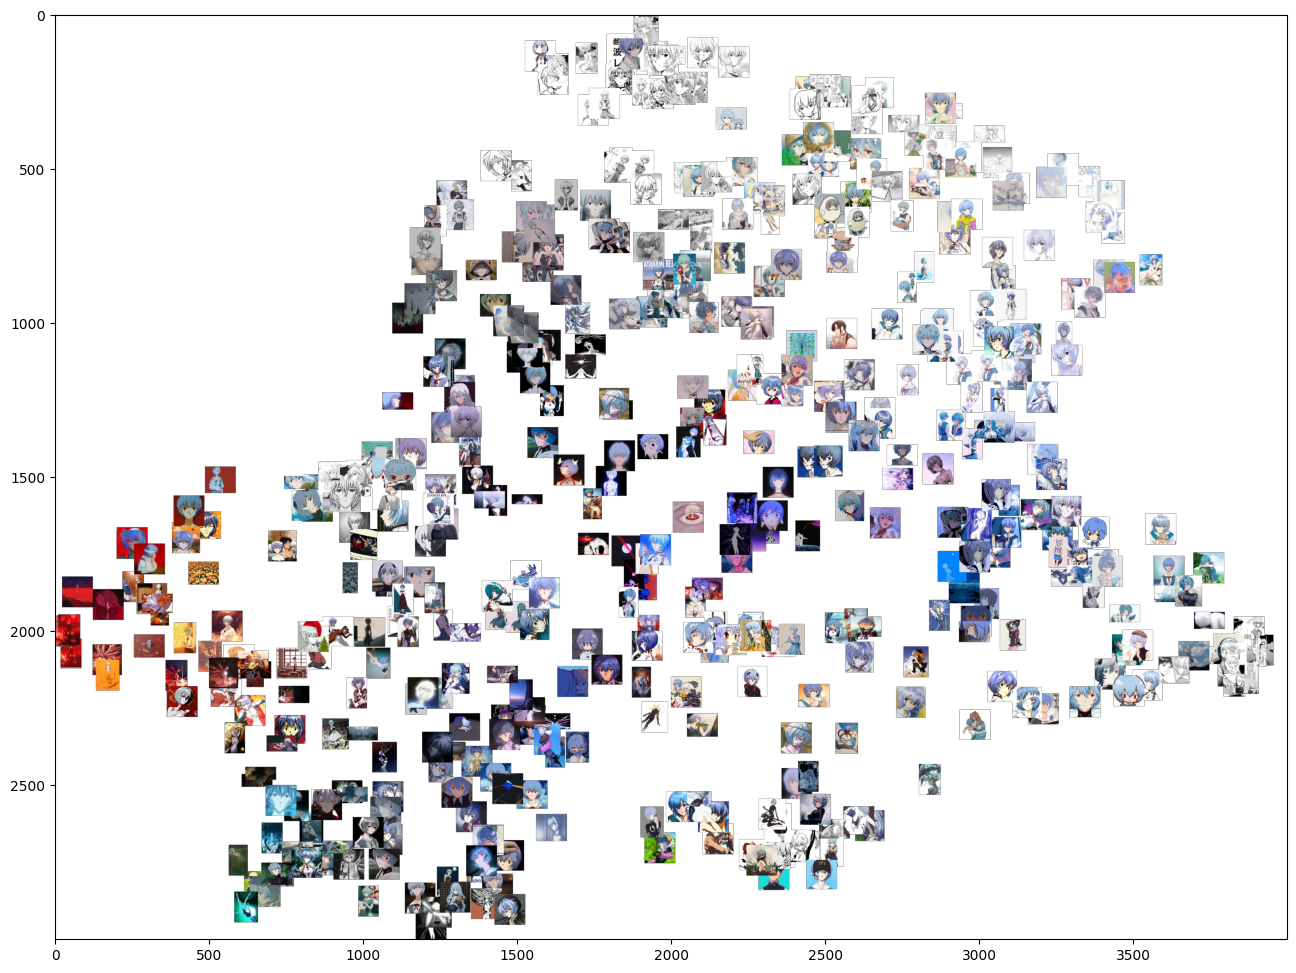

In [7]:
n_neighbors = 15
min_dist = 0.3
plot_umap('colour palettes', colour_palettes, n_neighbors, min_dist)


## UMAP Visualisation 2: ImageNet Features

In [8]:
def get_imagenet_features(image_data):
  image_data = [cv2.resize(io.imread(image), (224, 224)) for image in image_data]
  image_data = np.float32(image_data)
  image_data /= 255
  image_data = np.array(image_data)

  model = applications.MobileNetV2(input_shape=(224,224,3), alpha=1.0, weights='imagenet', pooling=None)
  pred = model.predict(image_data)
  imagenet_features = pred.reshape(image_data.shape[0], -1)

  return imagenet_features

In [9]:
#get ImageNet features
imagenet_features = get_imagenet_features(images)

16/16 [==============================] - 24s 1s/step


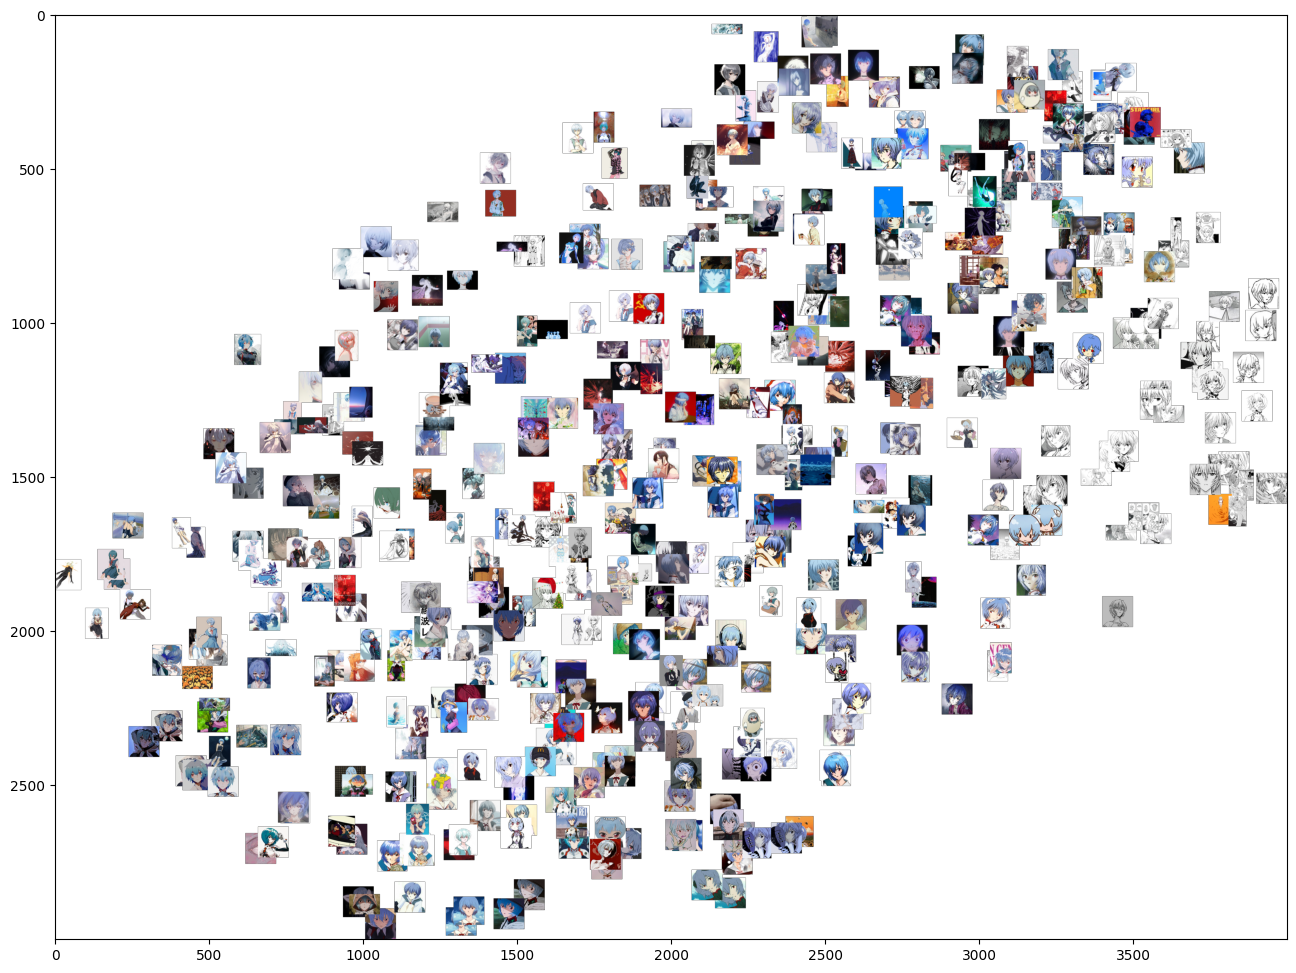

In [10]:
n_neighbors = 15
min_dist = 0.3

embedding = plot_umap('imagenet', imagenet_features, n_neighbors, min_dist)